In [1]:
import cv2
import numpy as np
import os
from os import path as osp
from glob import glob
import matplotlib.pyplot as plt

from superpoint.settings import EXPER_PATH
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
exper_name = 'magic-point_fixed'
path = osp.join(EXPER_PATH, 'outputs/{}/'.format(exper_name))
files = glob(osp.join(path, '*.npz'))
names = [osp.splitext(osp.split(f)[1])[0] for f in files]

In [3]:
def draw_keypoints(img, corners, color):
    keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(corners).T]
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

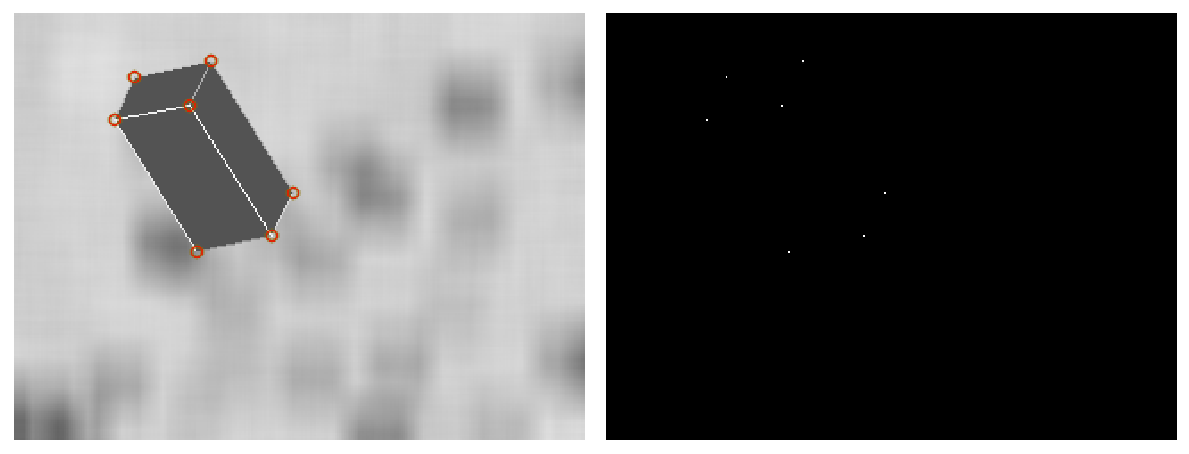

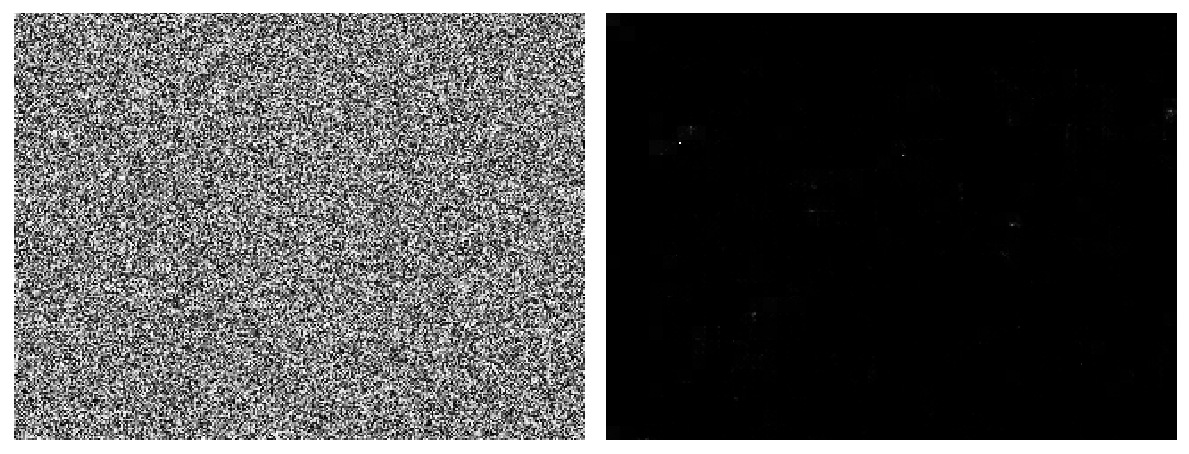

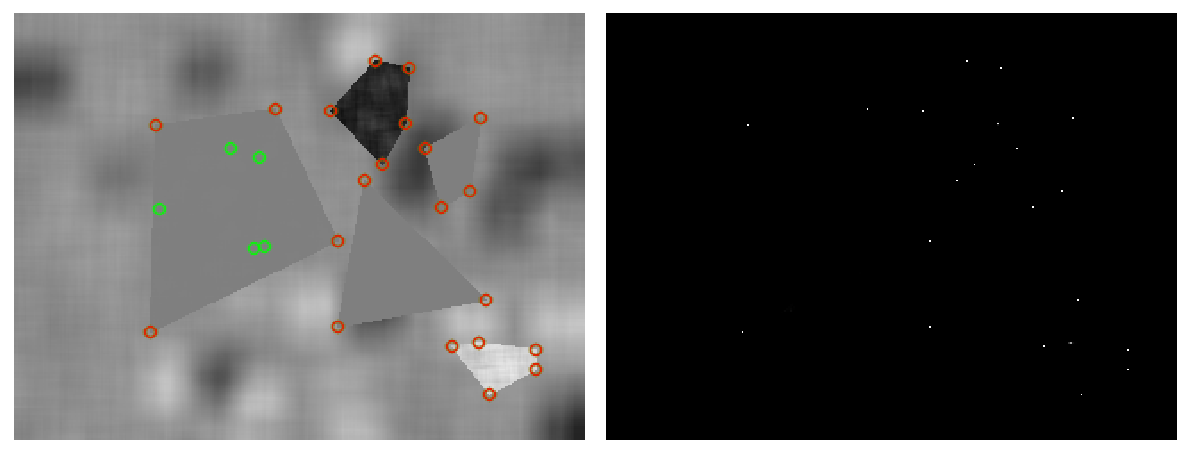

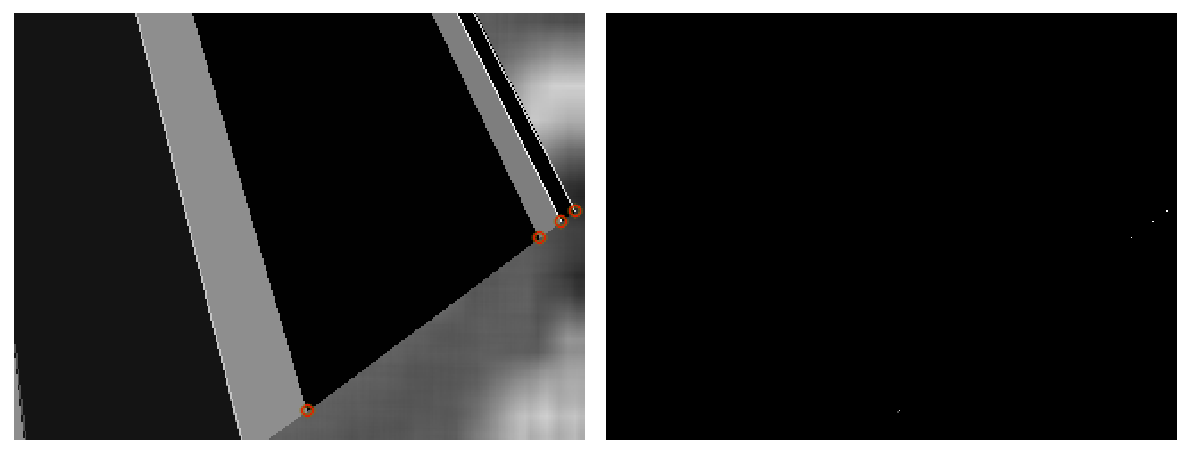

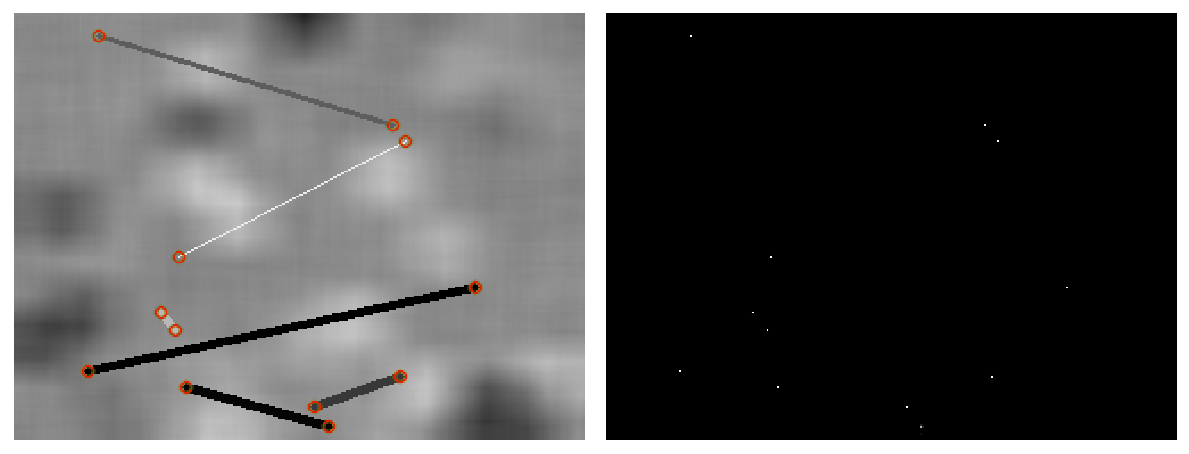

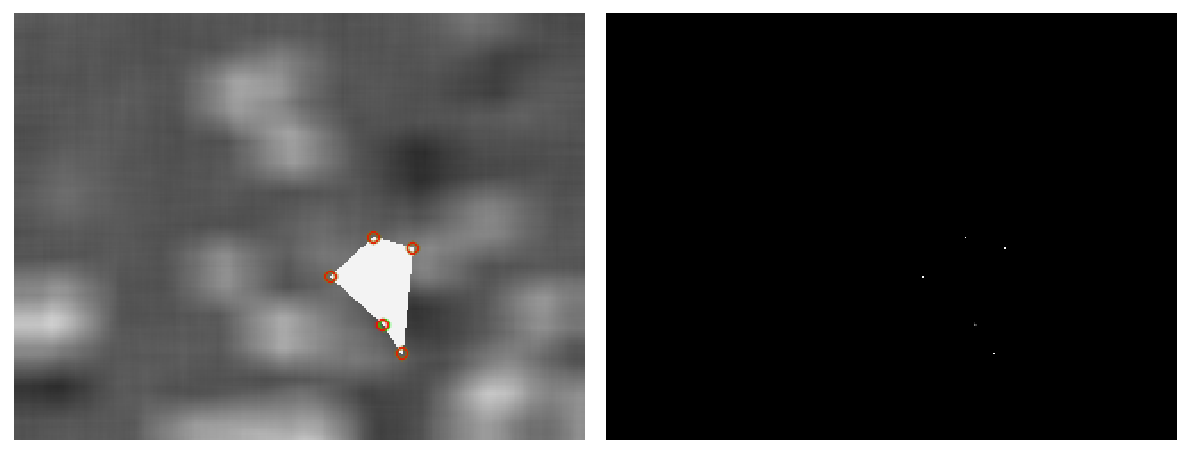

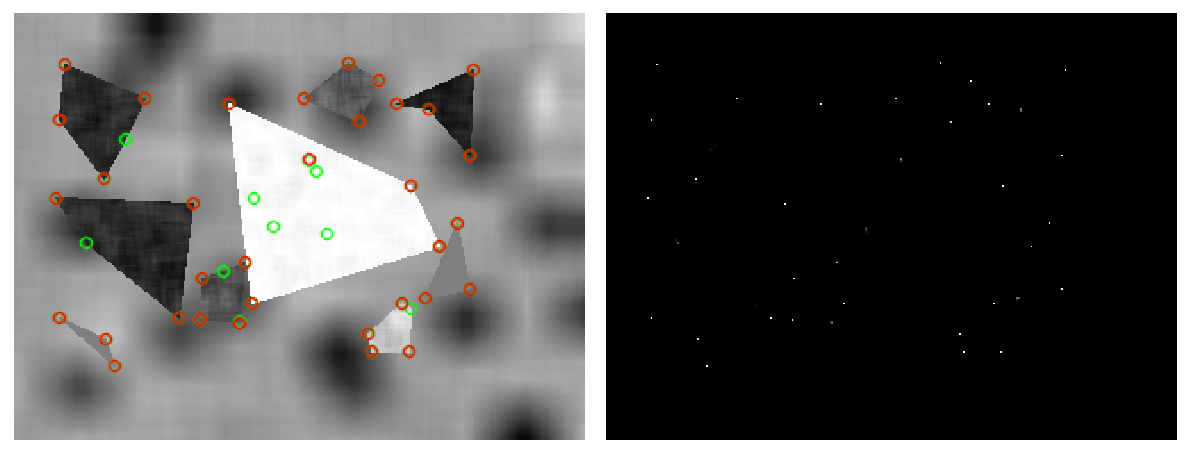

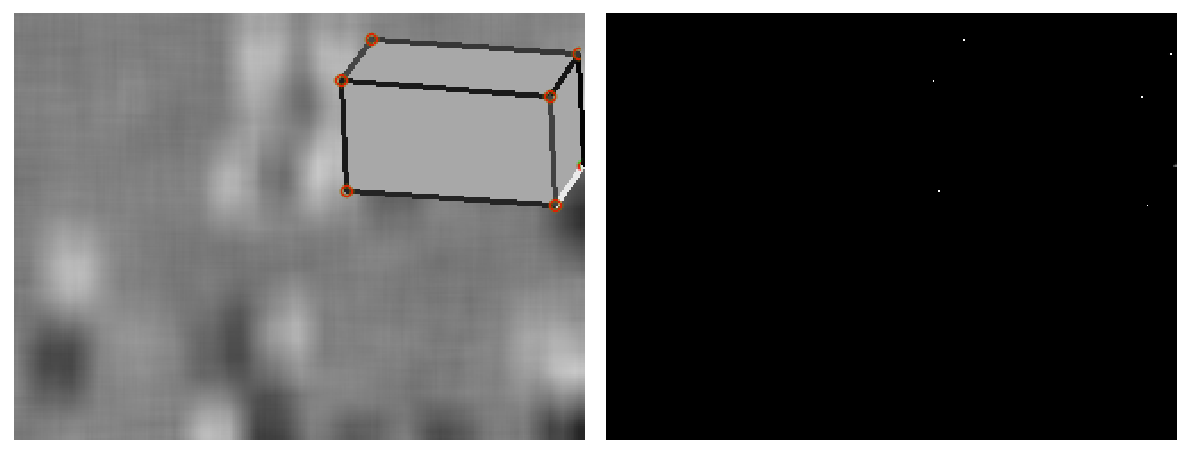

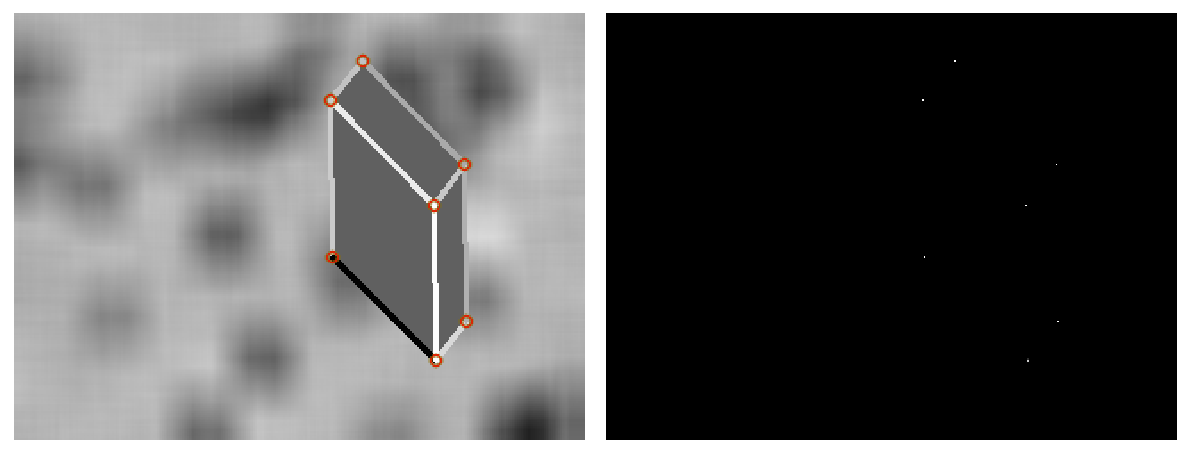

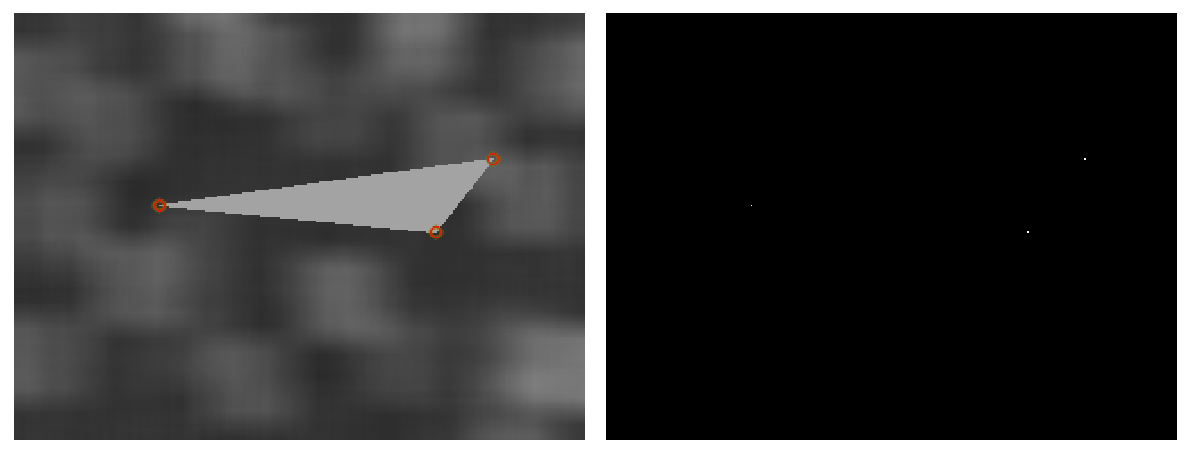

In [4]:
n = 10
for i in range(n):
    data = np.load(files[i])
    corners = np.where(data['prob'] > 0.4)
    gt = np.where(data['keypoint_map'])
    img = draw_keypoints(data['image'], gt, (0, 255, 0))
    img = draw_keypoints(img, corners, (0, 0, 255))
    plot_imgs([img/255., data['prob']/np.max(data['prob'])], cmap=['gray', 'gray'])

## Average Precision

In [5]:
def compute_tp_fp(data, remove_zero=1e-4, distance_thresh=2, simplified=False):
    # Read data
    gt = np.where(data['keypoint_map'])
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    prob = data['prob']

    # Filter out predictions with near-zero probability
    mask = np.where(prob > remove_zero)
    prob = prob[mask]
    pred = np.array(mask).T
    
    # When several detections match the same ground truth point, only pick
    # the one with the highest score  (the others are false positive)
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]

    # Compute 
    diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, distance_thresh)
    
    tp = []
    matched = np.zeros(len(gt))
    for m in matches:
        correct = np.any(m)
        if correct:
            gt_idx = np.argmax(m)
            tp.append(not matched[gt_idx])
            matched[gt_idx] = 1
        else:
            tp.append(False)
    tp = np.array(tp, bool)
    if simplified:
        tp = np.any(matches, axis=1)  # keeps multiple matches for the same gt point
        n_gt = np.sum(np.minimum(np.sum(matches, axis=0), 1)) # buggy
    fp = np.logical_not(tp)
    return tp, fp, prob, n_gt
def div0( a, b ):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        idx = ~np.isfinite(c)
        c[idx] = np.where(a[idx] == 0, 1, 0)  # -inf inf NaN
    return c

mAP: 0.9688580231451107
Operating probability threshold 1: 0.3136754333972931
Operating probability threshold 2: 0.48159393668174744


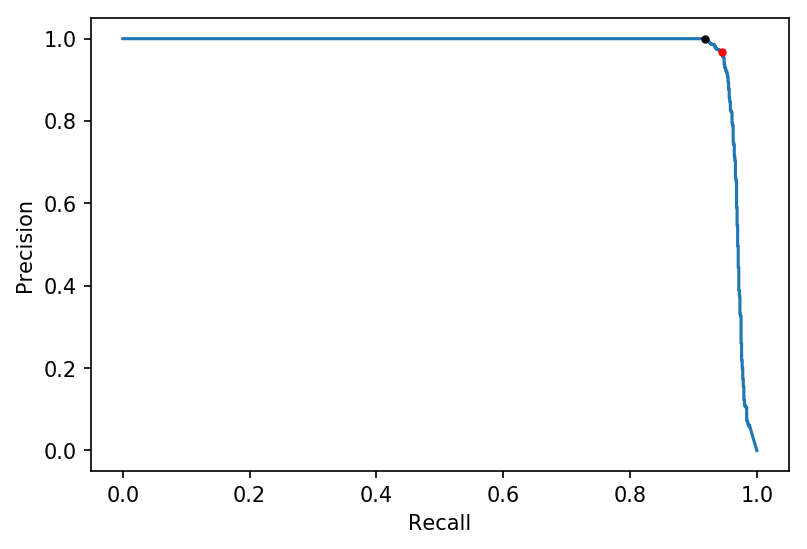

In [6]:
tp, fp, prob, n_gt = [], [], [], 0
for i in range(100):
    data = np.load(files[i])
    t, f, p, n = compute_tp_fp(data, distance_thresh=4)
    tp.append(t)
    fp.append(f)
    prob.append(p)
    n_gt += n
tp = np.concatenate(tp)
fp = np.concatenate(fp)
prob = np.concatenate(prob)

sort_idx = np.argsort(prob)[::-1]
tp = tp[sort_idx]
fp = fp[sort_idx]
prob = prob[sort_idx]

tp_cum = np.cumsum(tp)
fp_cum = np.cumsum(fp)
recall = div0(tp_cum, n_gt)
precision = div0(tp_cum, tp_cum + fp_cum)

recall = np.concatenate([[0], recall, [1]])
precision = np.concatenate([[0], precision, [0]])
precision = np.maximum.accumulate(precision[::-1])[::-1]

mAP = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
op_idx1 = np.argmin(np.linalg.norm([1-precision, 1-recall], axis=0))
op_idx2 = np.max(np.where(precision > 0.999))

print('mAP: {}'.format(mAP))
print('Operating probability threshold 1: {}'.format(prob[op_idx1]))
print('Operating probability threshold 2: {}'.format(prob[op_idx2]))

plt.figure(dpi=150)
plt.plot(recall, precision);
plt.plot(recall[op_idx1], precision[op_idx1], marker='o', color='r', markersize=3)
plt.plot(recall[op_idx2], precision[op_idx2], marker='o', color='k', markersize=3)
plt.xlabel('Recall'), plt.ylabel('Precision');

## Localization Error

In [7]:
def compute_loc_error(data, prob_thresh=0.5, distance_thresh=2):
    # Read data
    gt = np.where(data['keypoint_map'])
    gt = np.stack([gt[0], gt[1]], axis=-1)
    prob = data['prob']

    # Filter out predictions
    mask = np.where(prob > prob_thresh)
    pred = np.array(mask).T
    prob = prob[mask]
    
    if not len(gt) or not len(pred):
        return []
    
    diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
    dist = np.linalg.norm(diff, axis=-1) 
    dist = np.min(dist, axis=1)
    correct_dist = dist[np.less_equal(dist, distance_thresh)]
    return correct_dist

In [8]:
error = []
for i in range(100):
    data = np.load(files[i])
    error.append(compute_loc_error(data, distance_thresh=4))
error = np.mean(np.concatenate(error))
print('Localization error: {}'.format(error))

Localization error: 0.04043399744077833
